<a href="https://colab.research.google.com/github/freedom-780/Psychedelic-mushrooms/blob/main/Psychedelic_mushrooms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
pd.options.display.float_format = '{:,.3f}'.format

import xgboost as xgb 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import recall_score,accuracy_score, f1_score, precision_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix

import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline


In [2]:
def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

In [3]:
#Import data from github
data = "https://raw.githubusercontent.com/freedom-780/Psychedelic-mushrooms/main/AHRI_DATASET_PM_MANUSCRIPT_DATA.csv"
p_mush_df = pd.read_csv(data)

In [4]:
p_mush_df.shape

(7139, 57)

In [5]:
# copy dataframe for analysis to preserve original dataframe
df = p_mush_df.copy()

In [6]:
# Set index to case ID since every caseID is Unique
df.set_index('CASEID_7139', inplace=True)

In [7]:
df.columns

Index(['COHORTS', 'PYS_USE_VENN', 'PSY_USE_YN', 'PM_USE_YN', 'PM_USE_ONLY_YN',
       'PM_VS_PSY_YN', 'SEX', 'AGE', 'ETHNICITY', 'HLS_YN', 'REGION', 'ED',
       'EMPL', 'INCOME', 'BMI', 'C_TOTAL', 'C_DP', 'C_ANX', 'C_PN', 'C_ALL',
       'C_MI', 'C_INSOM', 'C_HYP', 'C_DH', 'C_SA', 'C_GERD', 'C_CS', 'C_LIP',
       'CCI_SCORE', 'GAD7_SCORE', 'PHQ9_SCORE', 'GAD7_GE10', 'PHQ9_GE10',
       'PCS12', 'MCS12', 'VR6D', 'RU_PCP_YN', 'RU_SPECIAL_YN', 'RU_OTPCP_YN',
       'RU_UCC_YN', 'RU_OUTPT_YN', 'RU_ER_YN', 'RU_HSP_YN',
       'PSY1_POSITIVE_USE', 'PSY2_GEN_HEALTH', 'PSY2_DIAG_CONDITION',
       'PSY2_UNDIAG_CONCERN', 'PSY2_NO_KNOWLEDGE', 'PM1_GEN_HEALTH',
       'PM1_DIAG_CONDITION', 'PM1_UNDIAG_CONCERN', 'PM2_FREQ_COVID',
       'PM3_FREQ_POLITICS', 'PM4_CARE', 'INSURANCE', 'DATA_WEIGHT'],
      dtype='object')

In [8]:
df.head().T

CASEID_7139,1,2,3,4,5
COHORTS,1.000,1.000,1.000,1.000,1.000
PYS_USE_VENN,1.000,1.000,1.000,1.000,1.000
PSY_USE_YN,1.000,1.000,1.000,1.000,1.000
PM_USE_YN,1.000,1.000,1.000,1.000,1.000
PM_USE_ONLY_YN,1.000,1.000,1.000,1.000,1.000
PM_VS_PSY_YN,2.000,2.000,2.000,2.000,2.000
SEX,0.000,0.000,0.000,0.000,0.000
AGE,19.000,21.000,22.000,22.000,23.000
ETHNICITY,3.000,2.000,2.000,2.000,2.000
HLS_YN,1.000,0.000,0.000,0.000,0.000


This dataset has 57 columns initially, most of these were dropped, trying to predict the PHQ9 score(ranges from 0-27) that has different ranges for different severity of depression. Those rows that were dropped have to do with hostipals stays, previous conditions of the patient, etc. while these might be useful to the model, only the qualities of the patient and psychedelics use is of interest, at least initally, but will try different features, after trying out a simple model and testing.


In [9]:
df.drop(['COHORTS','PYS_USE_VENN', 'PM_USE_YN', 'PM_USE_ONLY_YN', 'PM_VS_PSY_YN', 'DATA_WEIGHT','PM1_GEN_HEALTH','PM1_DIAG_CONDITION', \
        'PM1_DIAG_CONDITION', 'PM1_UNDIAG_CONCERN','PM2_FREQ_COVID','PM3_FREQ_POLITICS','PM4_CARE', 'HLS_YN', 'GAD7_SCORE', \
         'GAD7_GE10','PHQ9_GE10','PCS12','MCS12','VR6D'], axis=1, inplace=True)

In [10]:
df.sample(5)

,PSY_USE_YN,SEX,AGE,ETHNICITY,REGION,ED,EMPL,INCOME,BMI,C_TOTAL,...,RU_UCC_YN,RU_OUTPT_YN,RU_ER_YN,RU_HSP_YN,PSY1_POSITIVE_USE,PSY2_GEN_HEALTH,PSY2_DIAG_CONDITION,PSY2_UNDIAG_CONCERN,PSY2_NO_KNOWLEDGE,INSURANCE
CASEID_7139,,,,,,,,,,,,,,,,,,,,,
1447,0.000,0,38.000,3.000,3.000,0.000,0.000,75353,41.030,4.000,...,0,1,0,0,5,1,1,1,0,1
1945,0.000,0,45.000,3.000,1.000,1.000,0.000,82220,43.040,0.000,...,0,0,0,0,5,0,0,0,1,1
1732,0.000,0,42.000,2.000,4.000,0.000,0.000,73682,33.810,9.000,...,0,0,0,0,4,0,1,1,0,1
1743,0.000,0,42.000,2.000,4.000,0.000,0.000,58193,36.610,2.000,...,0,0,0,0,3,0,0,0,1,0
3785,0.000,0,79.000,2.000,3.000,1.000,0.000,63063,29.860,3.000,...,0,0,0,0,4,0,0,0,1,1


some of these columns have -99 representing other values some need to remap these

In [11]:
df.head().T

CASEID_7139,1,2,3,4,5
PSY_USE_YN,1.000,1.000,1.000,1.000,1.000
SEX,0.000,0.000,0.000,0.000,0.000
AGE,19.000,21.000,22.000,22.000,23.000
ETHNICITY,3.000,2.000,2.000,2.000,2.000
REGION,4.000,2.000,4.000,3.000,2.000
ED,0.000,1.000,0.000,1.000,0.000
EMPL,0.000,0.000,0.000,0.000,1.000
INCOME,"65,847.000","30,585.000","49,259.000","54,135.000","49,425.000"
BMI,27.410,29.260,20.600,18.560,36.800
C_TOTAL,3.000,0.000,9.000,2.000,4.000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7139 entries, 1 to 7139
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PSY_USE_YN           7139 non-null   float64
 1   SEX                  7139 non-null   int64  
 2   AGE                  7139 non-null   float64
 3   ETHNICITY            7139 non-null   float64
 4   REGION               7139 non-null   float64
 5   ED                   7139 non-null   float64
 6   EMPL                 7139 non-null   float64
 7   INCOME               7139 non-null   int64  
 8   BMI                  7139 non-null   float64
 9   C_TOTAL              7139 non-null   float64
 10  C_DP                 7139 non-null   float64
 11  C_ANX                7139 non-null   float64
 12  C_PN                 7139 non-null   float64
 13  C_ALL                7139 non-null   float64
 14  C_MI                 7139 non-null   float64
 15  C_INSOM              7139 non-null   f

there are a few columns that have the wrong **data type** such as **PSY_USE_YN** that should be integers not floats

In [13]:
# make a dataframe of columns to convert to int64
convert_cols = {
                'PSY_USE_YN':'int64',
                'SEX':'int64',
                'ETHNICITY':'int64',
                'REGION':'int64',
                'ED':'int64',
                'EMPL':'int64'
                              
               }

In [14]:
df = df.astype(convert_cols)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7139 entries, 1 to 7139
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PSY_USE_YN           7139 non-null   int64  
 1   SEX                  7139 non-null   int64  
 2   AGE                  7139 non-null   float64
 3   ETHNICITY            7139 non-null   int64  
 4   REGION               7139 non-null   int64  
 5   ED                   7139 non-null   int64  
 6   EMPL                 7139 non-null   int64  
 7   INCOME               7139 non-null   int64  
 8   BMI                  7139 non-null   float64
 9   C_TOTAL              7139 non-null   float64
 10  C_DP                 7139 non-null   float64
 11  C_ANX                7139 non-null   float64
 12  C_PN                 7139 non-null   float64
 13  C_ALL                7139 non-null   float64
 14  C_MI                 7139 non-null   float64
 15  C_INSOM              7139 non-null   f

looks like the columns are the correct data types now 

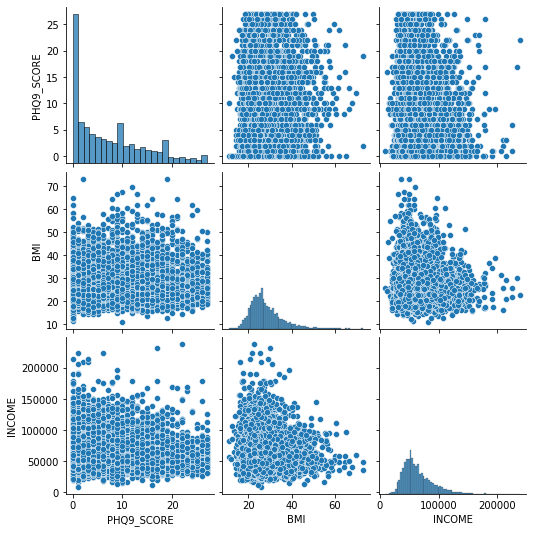

In [16]:
sns.pairplot(df[['PHQ9_SCORE', 'BMI', 'INCOME']]);

looks like PHQ9_SCORE(Depression Score) and GAD7_Score(Anxiety) and positively correlated, would be better for the model if one of these were dropped, the interest for this analysis is in the PHQ9 score, which is more of a sevre indicator

The dataset seems to be unbalanced with more 0 than 1s if we were going to classify psychedelics use. Even though predicting psychedelic use based on the other features, a more interesting question is predicting the depression score based on the other features. This way you can have some idea of their beanift

Would like to use **PM_USE_ONLY_YN** or **PSY_USE_YN** the **PSY_USE_YN**(which is psychedelics used as a 1 or 0 otherwise) yet different psychedelics have different effects on mind based on research, but it's a good start for a simplified model

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PSY_USE_YN,"7,139.000",0.074,0.261,0.000,0.000,0.000,0.000,1.000
SEX,"7,139.000",0.455,0.498,0.000,0.000,0.000,1.000,1.000
AGE,"7,139.000",46.147,16.648,18.000,33.000,43.000,60.000,95.000
ETHNICITY,"7,139.000",1.952,0.506,1.000,2.000,2.000,2.000,3.000
REGION,"7,139.000",2.632,0.998,1.000,2.000,3.000,3.000,4.000
ED,"7,139.000",0.726,0.446,0.000,0.000,1.000,1.000,1.000
EMPL,"7,139.000",0.305,0.460,0.000,0.000,0.000,1.000,1.000
INCOME,"7,139.000","64,563.706","26,258.629","9,076.000","46,322.500","58,129.000","77,263.000","237,841.000"
BMI,"7,139.000",28.025,7.255,11.160,23.050,26.580,31.415,73.120
C_TOTAL,"7,139.000",4.096,3.640,0.000,1.000,3.000,6.000,28.000


In [18]:

print(f"Shape data: {df.shape}")
print(f"Number of mission values in data: \
{df.isnull().sum().sum()}")
print(f"Number of duplicate values in data: \
{df.duplicated().sum()}")

Shape data: (7139, 37)
Number of mission values in data: 0
Number of duplicate values in data: 2


In [19]:
df[df.duplicated()]

,PSY_USE_YN,SEX,AGE,ETHNICITY,REGION,ED,EMPL,INCOME,BMI,C_TOTAL,...,RU_UCC_YN,RU_OUTPT_YN,RU_ER_YN,RU_HSP_YN,PSY1_POSITIVE_USE,PSY2_GEN_HEALTH,PSY2_DIAG_CONDITION,PSY2_UNDIAG_CONCERN,PSY2_NO_KNOWLEDGE,INSURANCE
CASEID_7139,,,,,,,,,,,,,,,,,,,,,
533,0,0,25.000,2,4,0,0,93374,27.460,0.000,...,0,0,0,0,3,0,0,0,1,1
5236,0,1,41.000,2,3,1,1,76014,20.870,0.000,...,0,0,0,0,3,0,0,0,1,0


In [20]:
df.nunique()

PSY_USE_YN                2
SEX                       2
AGE                      76
ETHNICITY                 3
REGION                    4
ED                        2
EMPL                      2
INCOME                 4890
BMI                    1551
C_TOTAL                  28
C_DP                      2
C_ANX                     2
C_PN                      2
C_ALL                     2
C_MI                      2
C_INSOM                   2
C_HYP                     2
C_DH                      2
C_SA                      2
C_GERD                    2
C_CS                      2
C_LIP                     2
CCI_SCORE                10
PHQ9_SCORE               28
RU_PCP_YN                 2
RU_SPECIAL_YN             2
RU_OTPCP_YN               2
RU_UCC_YN                 2
RU_OUTPT_YN               2
RU_ER_YN                  2
RU_HSP_YN                 2
PSY1_POSITIVE_USE         5
PSY2_GEN_HEALTH           2
PSY2_DIAG_CONDITION       2
PSY2_UNDIAG_CONCERN       2
PSY2_NO_KNOWLEDGE   

<Figure size 1080x1080 with 0 Axes>

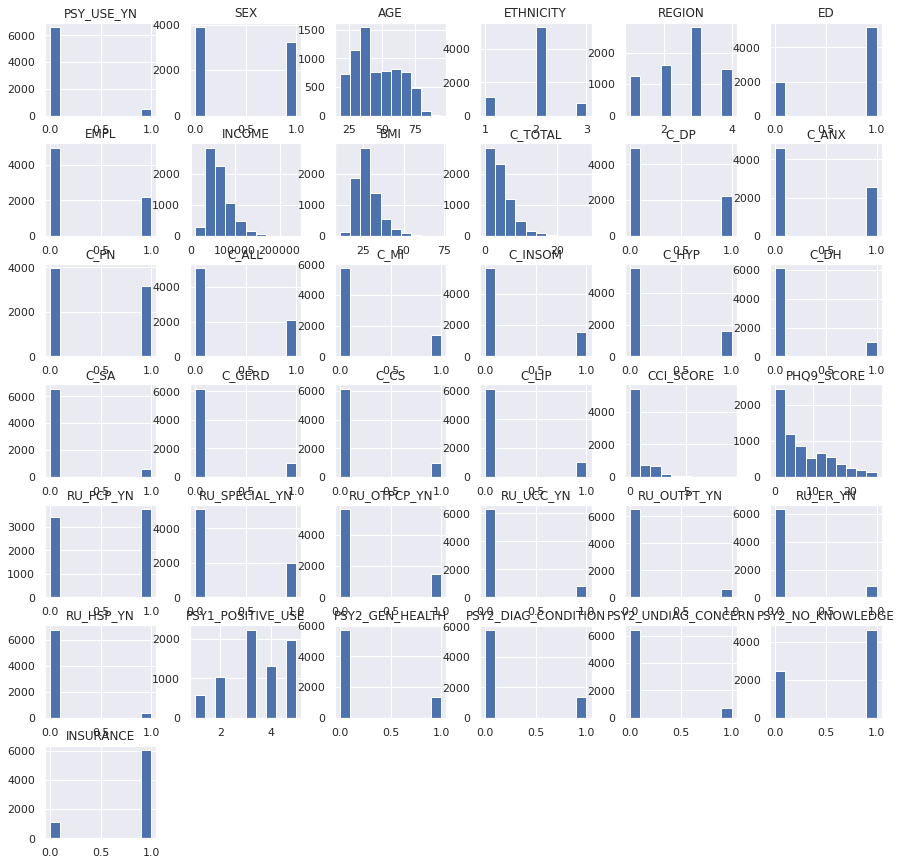

In [21]:
sns.set(rc = {'figure.figsize':(15,15)})
plt.tight_layout()
df.hist();

Most of the data seems to be shewed with left tails, may need to do transformations on the data such as standardization 

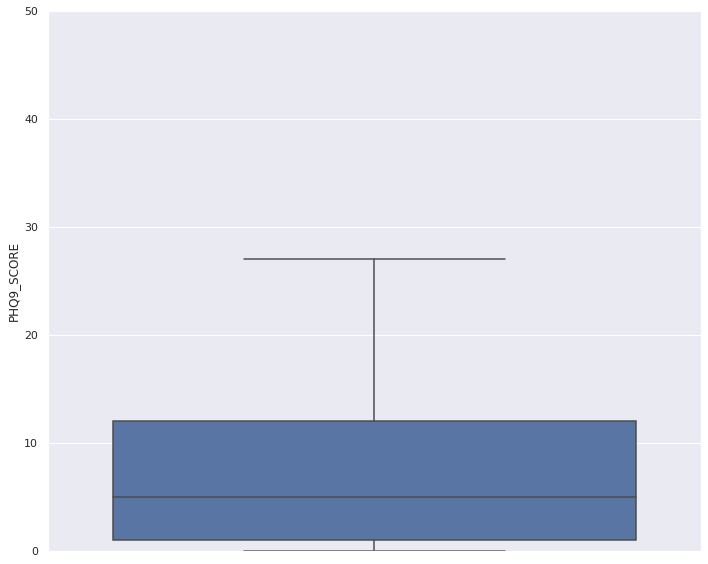

In [22]:
sns.set(rc = {'figure.figsize':(10,8)})
sns.boxplot(y ='PHQ9_SCORE',data=df)
plt.ylim(0, 50)
plt.tight_layout()

seems there are no outliers for the dependent vaiable

In [23]:
df['PHQ9_SCORE'].describe()

count   7,139.000
mean        7.330
std         6.994
min         0.000
25%         1.000
50%         5.000
75%        12.000
max        27.000
Name: PHQ9_SCORE, dtype: float64

**PHQ9_SCORE** has a range of 0-27, and several increasing depression categories and needs to be remapped 

In [24]:
# define function to use with apply and lambda to remap PHQ9_SCORE column

def PHQ9_remap_1(x):
    if (x >= 0) & (x <= 4):
        x = 1
    elif (x >= 5) & (x <= 9):
        x = 2
    elif (x >= 10) & (x <= 14):
        x = 3
    elif (x >= 15) & (x <= 19):
        x = 4 
    else:
        x = 5

    return x 

    
    



In [25]:
df['PHQ9_SCORE'] = df.apply(lambda x: PHQ9_remap_1(x['PHQ9_SCORE']), axis=1)

In [26]:
df['PHQ9_SCORE']

CASEID_7139
1       2
2       1
3       4
4       4
5       4
       ..
7135    3
7136    1
7137    1
7138    1
7139    1
Name: PHQ9_SCORE, Length: 7139, dtype: int64

In [27]:
df['PHQ9_SCORE'].value_counts()

1    3286
2    1490
3    1097
4     774
5     492
Name: PHQ9_SCORE, dtype: int64

We can see that the PHQ9 score is unbalanced, but thinking about this from a health prespective, those that are > category 1(minimal depression) don't need any type of help or action, so we will remap this into 0 needing no action and 1 needing action.

In [28]:
def PHQ9_remap_2 (x):
  if x == 1:
    x = 0
  else: 
    x = 1
  return x 

In [29]:
df['PHQ9_SCORE'] = df.apply(lambda x: PHQ9_remap_2(x['PHQ9_SCORE']), axis=1)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7139 entries, 1 to 7139
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PSY_USE_YN           7139 non-null   int64  
 1   SEX                  7139 non-null   int64  
 2   AGE                  7139 non-null   float64
 3   ETHNICITY            7139 non-null   int64  
 4   REGION               7139 non-null   int64  
 5   ED                   7139 non-null   int64  
 6   EMPL                 7139 non-null   int64  
 7   INCOME               7139 non-null   int64  
 8   BMI                  7139 non-null   float64
 9   C_TOTAL              7139 non-null   float64
 10  C_DP                 7139 non-null   float64
 11  C_ANX                7139 non-null   float64
 12  C_PN                 7139 non-null   float64
 13  C_ALL                7139 non-null   float64
 14  C_MI                 7139 non-null   float64
 15  C_INSOM              7139 non-null   f

In [31]:
df['PHQ9_SCORE'].sample(10)

CASEID_7139
4413    1
1754    1
298     1
2794    1
289     1
6597    0
4096    1
5493    0
500     1
3988    1
Name: PHQ9_SCORE, dtype: int64

In [32]:
df['PHQ9_SCORE'].value_counts()

1    3853
0    3286
Name: PHQ9_SCORE, dtype: int64

In [33]:
df['PSY_USE_YN'].value_counts()

0    6613
1     526
Name: PSY_USE_YN, dtype: int64

looks like the 'PSY_USE_YN' column is unbalanced 

In [34]:
df.head()

,PSY_USE_YN,SEX,AGE,ETHNICITY,REGION,ED,EMPL,INCOME,BMI,C_TOTAL,...,RU_UCC_YN,RU_OUTPT_YN,RU_ER_YN,RU_HSP_YN,PSY1_POSITIVE_USE,PSY2_GEN_HEALTH,PSY2_DIAG_CONDITION,PSY2_UNDIAG_CONCERN,PSY2_NO_KNOWLEDGE,INSURANCE
CASEID_7139,,,,,,,,,,,,,,,,,,,,,
1,1,0,19.000,3,4,0,0,65847,27.410,3.000,...,0,0,0,0,3,1,0,0,0,0
2,1,0,21.000,2,2,1,0,30585,29.260,0.000,...,0,0,1,0,1,0,0,1,0,1
3,1,0,22.000,2,4,0,0,49259,20.600,9.000,...,1,0,1,0,3,1,1,1,0,0
4,1,0,22.000,2,3,1,0,54135,18.560,2.000,...,0,0,0,0,2,1,1,0,0,1
5,1,0,23.000,2,2,0,1,49425,36.800,4.000,...,0,0,1,0,2,1,1,1,0,1


the dataframe is properly cleaned and encoded now, now we need to split the data into train/test sets and scale the continous data features

In [35]:
df_clean = df 

In [36]:
df_clean.sample(5)

,PSY_USE_YN,SEX,AGE,ETHNICITY,REGION,ED,EMPL,INCOME,BMI,C_TOTAL,...,RU_UCC_YN,RU_OUTPT_YN,RU_ER_YN,RU_HSP_YN,PSY1_POSITIVE_USE,PSY2_GEN_HEALTH,PSY2_DIAG_CONDITION,PSY2_UNDIAG_CONCERN,PSY2_NO_KNOWLEDGE,INSURANCE
CASEID_7139,,,,,,,,,,,,,,,,,,,,,
1472,0,0,38.000,2,3,1,0,81445,28.240,0.000,...,0,0,0,0,3,0,0,0,1,1
3824,0,0,84.000,2,1,0,0,57649,20.980,5.000,...,0,0,0,0,5,0,0,0,1,1
4869,0,1,38.000,2,3,1,1,52245,18.370,3.000,...,0,0,0,1,2,0,0,0,1,0
4792,0,1,36.000,2,3,1,1,30000,21.700,0.000,...,0,0,0,0,5,0,0,0,1,1
105,1,1,45.000,2,3,1,1,88562,26.580,4.000,...,0,0,0,0,2,1,1,0,0,1


#Modeling

### Split data 

In [37]:
X, y = df_clean.loc[:, 'SEX': 'INSURANCE'].drop('PHQ9_SCORE', axis=1).values, df_clean.loc[:, 'PHQ9_SCORE'].values

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size =0.3, random_state = 0, \
                                                   stratify = y)

### Linear SVC Model

In [41]:
lsvc = LinearSVC( max_iter=5000,random_state =1)

plot_decision_regions(X, y, lsvc), resolution=0.02)



NotFittedError: ignored

In [ ]:

pipe_lr = make_pipeline(StandardScaler(),PCA(), 
                        LinearSVC( max_iter=5000,random_state =1))

In [ ]:
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_recall = recall_score(y_test, y_pred)
mcc_lr = matthews_corrcoef(y_test, y_pred)
print(f'Test recall: {test_recall}')
print(f'MCC: {mcc_lr}')

Test recall: 0.7517301038062284
MCC: 0.5240066872375015


In [ ]:
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_test, y_pred)
print(confmat)

[[763 223]
 [287 869]]


Text(0, 0.5, 'True label')

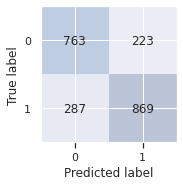

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.2)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j],va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')


** tune models, try Xboost, once you find the best model, use emsemble methods, create slide deck, then report **

** tune models, try Xboost, once you find the best model, use emsemble methods, create slide deck, then report **

### SVC Kernel Model

In [ ]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=0))

For this problem we care more about recall as a performance, which minimises false negatives as oposed to precision which minimised false positives

In [ ]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
test_recall = recall_score(y_test, y_pred)
print(f'Test recall: {test_recall}')

Test recall: 0.759515570934256


In [ ]:
confmat = confusion_matrix(y_test, y_pred)
print(confmat)

[[740 246]
 [278 878]]


Text(0, 0.5, 'True label')

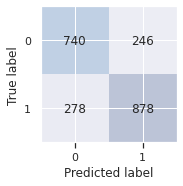

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.2)
for i in range(confmat.shape[0]):
  for j in range(confmat.shape[1]):
    ax.text(x=j, y=i, s=confmat[i, j],va='center', ha='center')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')

In [ ]:
train_sizes, train_scores, test_scores =\
                 learning_curve(estimator=pipe_svc,
                                X=X_train,
                                y=y_train,
                                train_sizes=np.linspace(
                                            0.1, 1.0, 10),cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
          color='blue', marker='o',
          markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                  train_mean + train_std,
                  train_mean - train_std,
                  alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
          color='green', linestyle='--',
          marker='s', markersize=5,
          label='Validation accuracy')
plt.fill_between(train_sizes,
                  test_mean + test_std,
                  test_mean - test_std,
                  alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

KeyboardInterrupt: ignored

trying some feature selection 

t

In [ ]:
labels = df_clean.loc[:, 'SEX': 'INSURANCE'].drop('PHQ9_SCORE', axis=1).columns 

### Random Forest Feature Selection

used random forest for feature selection 

In [ ]:
feat_labels = labels
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], \
                          importances[indices[f]]))
plt.title('Feature importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()

diagnp

This current model has high bias, and we should try including more features in the model 

### Logistic Regression

In [ ]:
pipe_lr = make_pipeline(StandardScaler(),
                    LogisticRegression(max_iter=10000,random_state =1))


### Ensomble Methods

In [ ]:
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=.03, 
                          max_depth= 4, random_state=1)

gbm = model.fit(X_train, y_train)
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)
gbm_train = recall_score(y_train, y_train_pred)
gbm_test = recall_score(y_test, y_test_pred)

print(f'XGboost train/test accuracies: {gbm_train}/{gbm_test}')

XGboost train/test accuracies: 0.8364849833147943/0.7707612456747405


In [ ]:
train_sizes, train_scores, test_scores =\
                 learning_curve(estimator=pipe_lr,
                                X=X_train,
                                y=y_train,
                                train_sizes=np.linspace(
                                            0.1, 1.0, 10),cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
          color='blue', marker='o',
          markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                  train_mean + train_std,
                  train_mean - train_std,
                  alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
          color='green', linestyle='--',
          marker='s', markersize=5,
          label='Validation accuracy')
plt.fill_between(train_sizes,
                  test_mean + test_std,
                  test_mean - test_std,
                  alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')